### ライブラリインポート

In [1]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

from scipy.stats import binom

import pymc as pm
import arviz as az

## 10.1 例題: 個体差と生存種子数(個体差あり)

In [2]:
data = pl.read_csv("../data/ch 10/data7a.csv").to_pandas()
data

,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1
...,...,...
95,96,1
96,97,0
97,98,4
98,99,7


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


([<matplotlib.axis.YTick at 0x210b8a4a210>,
 [Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10'),
  Text(0, 15, '15'),
  Text(0, 20, '20')])

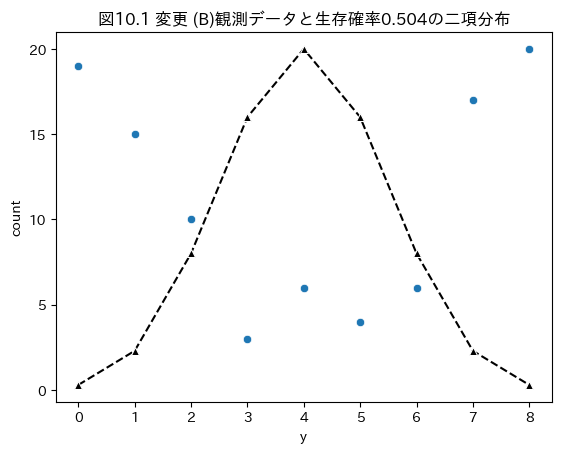

In [3]:
data_count = data["y"].value_counts().reset_index()

y1 = range(0, 9)
rv = binom(n = 8, p = 0.5)
count1 = rv.pmf(y1)
count1 = count1 / np.max(count1) * data_count["count"].max()


sns.scatterplot(data = data_count, x = "y", y = "count")
sns.lineplot(x = y1, y = count1, marker = "^", linestyle = "--", color = "black")

plt.title("図10.1 変更 (B)観測データと生存確率0.504の二項分布")
plt.yticks([0, 5, 10, 15, 20])

## 10.2 GLMMの階層ベイズ化

## 10.3 階層ベイズモデルの推定・予測

### 10.3.1 階層ベイズモデルのMCMCサンプリング

#### 確率モデル定義

In [4]:
model1 = pm.Model()

number_of_seeds = 8

with model1:
    # 観測値
    y_i = pm.ConstantData('y_i', data["y"].to_numpy())

    # 無情報事前分布
    s = pm.Uniform(name = "s", lower = 0, upper = 1e4)
    # 階層事前分布
    r_i = pm.Normal(name = "r_i", mu = 0, sigma = s)
    # 無情報事前分布
    beta = pm.Normal(name = "beta", mu = 0, sigma = 1e2)
    # 生存確率
    q_i = pm.math.invlogit(beta + r_i)

    # 二項分布
    Y_obs = pm.Binomial(name = "binomial", n = number_of_seeds, p = q_i, observed = y_i)


#### 確率モデル構造可視化

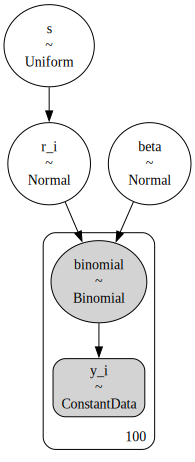

In [5]:
g = pm.model_to_graphviz(model1)
display(g)

#### サンプリング

In [6]:
with model1:
    idata1 = pm.sample(random_seed = 42)# , chains = 5, tune = 5, draws = 5

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, r_i, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 256 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### plot_trace 関数呼び出し

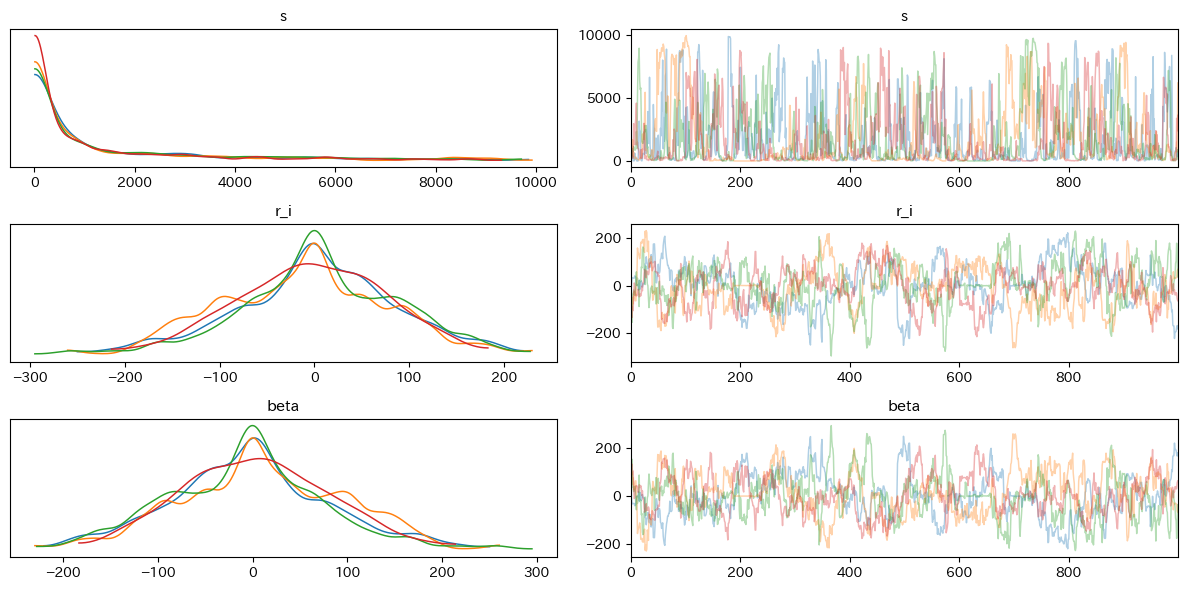

In [7]:
az.plot_trace(idata1, compact = False, var_names = ["s", "r_i", "beta"])
plt.tight_layout()

#### plot_posteror関数呼び出し

array([<Axes: title={'center': 's'}>, <Axes: title={'center': 'r_i'}>,
       <Axes: title={'center': 'beta'}>], dtype=object)

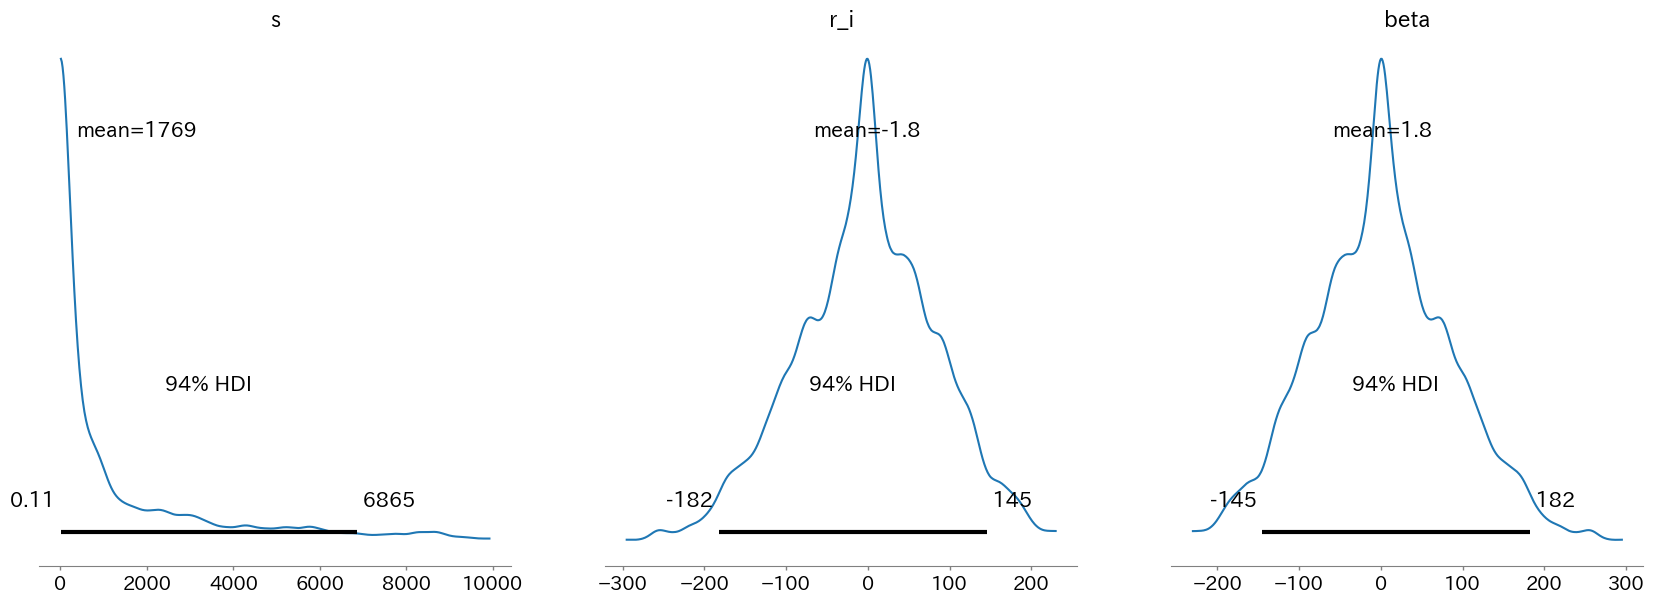

In [8]:
plt.rcParams['figure.figsize'] = (6, 6)
az.plot_posterior(idata1, var_names=["s", "r_i", "beta"])

### 10.3.2 階層ベイズモデルの事後分布推定と予測

## 10.4 ベイズモデルで使う様々な事前分布

## 10.5 個体差+場所差の階層ベイズモデル

## 10.6 この章のまとめと参考文献
* GLMMをベイズモデル化すると階層ベイズモデルになる.
* 階層ベイズモデルとは,事前分布となる確率分布のパラメータにも事前分布が指定されている.
* 無情報事前分布と階層事前分布を使うことで,ベイズ統計モデルから主観的な事前分布を排除できる.
* 個体差+場所差といった複雑な構造のあるデータの統計モデリングでは,階層ベイズモデルとMCMCサンプリングによるパラメータ推定の組合せで対処するのが良い

* 鈴木・国友編「ベイズ統計学とその応用」